# Post-Insight Refactoring
Tristan Miller, 12/6/2019

I originally spent three weeks on this project, which required that several components were rushed.  Looking back, there are several parts I would do differently, and this notebook is dedicated to making and tracking those changes.

An outline of planned changes:
1. Previously, musical frequencies outside of range were set to 0 dB.  There must be a better way to impute the data.
1. Review chord parsing.
1. Create a mini training set, especially for training models that are too high bias to need the data.
1. Allow code to train root models separately, for faster iteration.
1. Try convolutional and recurrent neural networks.
1. Use random hyperparameter searching.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Recalculating-features" data-toc-modified-id="Recalculating-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recalculating features</a></span><ul class="toc-item"><li><span><a href="#Reviewing-chord-parsing" data-toc-modified-id="Reviewing-chord-parsing-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reviewing chord parsing</a></span></li><li><span><a href="#Improved-imputation" data-toc-modified-id="Improved-imputation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Improved imputation</a></span></li></ul></li></ul></div>

## Setup

In [58]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sys, os
from sklearn.model_selection import train_test_split
import sklearn
import re
import pickle
import xgboost as xgb
import sklearn
from xgboost import plot_importance

if 'chord_loader' in sys.modules:
    del sys.modules['chord_loader']
sys.path.append('.')
import chord_loader

In [103]:
#get directory and block_length
block_length = chord_loader.get_true_block(0.5,24.5,7,1)
song_directory = pd.read_csv('song_directory.csv')
valid_directory = song_directory.loc[np.logical_and(
    ~pd.isna(song_directory['mp3_filepath']),
    abs(song_directory['diff_length']) <= 5)]
song_list = valid_directory

## Recalculating features

### Reviewing chord parsing
This is all contained in chord_loader.py.  A list of changes:
1. C# is now the canonical representation of the note instead of Db.
1. Removed any special processing of sus2 chords.  They now read as power chords with an added 2nd.
1. Combined the list of intervals from the shorthand and written intervals.  This leads to more consistent identification of the quality and add.

The code below tests that my functions still works, and returns a list of all chords and labels.

In [81]:
all_labels = np.ndarray((0,4))
all_chords = pd.Series([])
for i, row in song_list.iterrows():
    if row.dataset == 'isophonics/The Beatles':
        sep = ' '
    else:
        sep = '\t'
    song_labels = chord_loader.get_labels(row.chord_filepath,sep,block_length)
    df = pd.read_csv(row.chord_filepath,sep=sep,header=None,names=["start_time","end_time","chord"])
    blocked_df = chord_loader.blockify(df,block_length)
    
    all_labels = np.concatenate((all_labels,song_labels),axis=0)
    all_chords = all_chords.append(blocked_df,ignore_index=True)

In [95]:
#testing that it looks right
print(all_labels[10500:20000:1000,:])
print(all_chords[10500:20000:1000])

[[ 4.  2.  7.  0.]
 [ 0.  4.  0.  0.]
 [ 9.  7.  0.  0.]
 [ 0.  7.  0.  0.]
 [ 2.  3.  0.  2.]
 [ 2.  3.  0.  0.]
 [ 9.  7.  0.  0.]
 [-1.  0.  0.  0.]
 [ 9.  7.  0.  0.]
 [11.  7.  0.  0.]]
10500      E:maj6
11500      C:sus4
12500           A
13500           C
14500    D:min/b3
15500       D:min
16500           A
17500           N
18500           A
19500           B
dtype: object


### Improved imputation
Previously, musical frequencies outside of range were set to 0 dB.  A better way to impute data, would be to set it to the volume of the largest/smallest frequency.

Testing below

In [154]:
#get a single song's spectra so I can do testing
filepath = song_list.iloc[0,:].mp3_filepath
minfreq = 24.5
num_octaves = 7
bins_per_note = 1

#code copied over from chord_loader.get_features
maxfreq = minfreq*(2**num_octaves)
sr = 4*maxfreq
hop_restriction = 2**(num_octaves-1)
hop_length = round(block_length*sr/hop_restriction)*hop_restriction
wav,sr_ = librosa.load(filepath,sr=sr)
cqt_options = {'sr':sr,
           'hop_length':hop_length,
           'fmin':minfreq,
           'n_bins':num_octaves*bins_per_note*12,
           'bins_per_octave':bins_per_note*12}
spec = librosa.cqt(wav, **cqt_options)
#convert to features
db = librosa.amplitude_to_db(np.abs(spec)).T
db_copy = db.copy()

In [155]:
#rewrite the rest of chord_loader.get_features, using better imputation
db = db_copy.copy()

db_mean = np.mean(db)
db_std = np.std(db)
db = (db - db_mean)/(db_std+.0001)
#features is padded out by one row, one column, plus column-space for transposition
features = np.zeros((db.shape[0]+1,11*bins_per_note+db.shape[1]+1))
features[1:,(5*bins_per_note+1):-(6*bins_per_note)] = db
features[1:,1:(5*bins_per_note+1)] = features[1:,5*bins_per_note+1].reshape(-1,1)
features[1:,-(6*bins_per_note):] = features[1:,-(6*bins_per_note+1)].reshape(-1,1)
#very first column/row is a flag for start of song
features[0,0] = 1

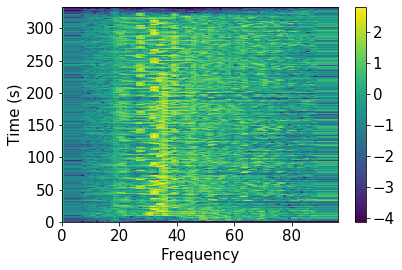

In [156]:
#test that it looks right
plt.pcolor(features)
plt.xlabel('Frequency')
plt.ylabel('Time (s)')
plt.rc('font', size=15)
plt.tight_layout()
plt.colorbar()

There are two other places where imputation occurs, in chord_loader.standardize_root, and 